Now we can make the spectroscopic light curves given all spectra are aligned and the wavelength solution has been calculated.

In [469]:
#%matplotlib inline

In [471]:
%matplotlib inline

In [509]:
import numpy as np
import reduction_utils.wavelength_binning as wb
import reduction_utils.wavelength_calibration as wc
import matplotlib.pyplot as plt
import pickle
import math

#import mpld3
#mpld3.enable_notebook()
#mpld3.disable_notebook()

First of all, I check what airmasses the data were taken at. If I have plenty of out of transit data, I will ignore data taken at airmass > 2. If not, I keep all data regardless of airmass.

I also check the sky background. If observations were taken at the end of the night, we sometimes observe into morning twilight and the sky background increases quickly and suddenly, which can introduce unwanted noise in the light curves.

Load in the airmass array:

1.15 1.049 1.938


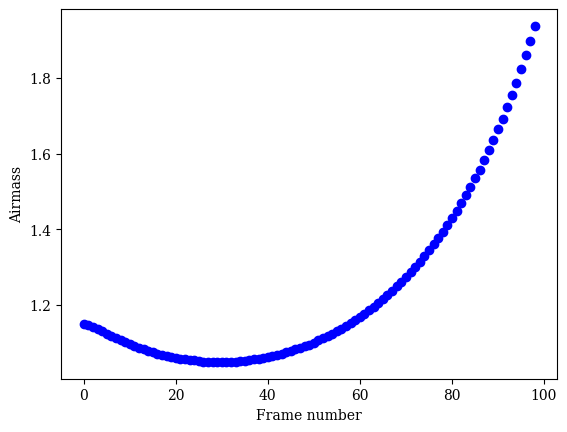

In [513]:
parent_direc = '/Users/u2257755/Library/CloudStorage/OneDrive-UniversityofWarwick/LRG_BEASTS/WASP-168/2023-01-25/reduction_2/'

am = pickle.load(open(parent_direc+'pickled_objects/airmass.pickle','rb'))

print(am[0],min(am),am[-1])

plt.figure()
plt.plot(am,'bo')
plt.ylabel('Airmass')
plt.xlabel('Frame number')
plt.show()

OK, so this case I don't need to perform an airmass cut. 

Also, now load in the input data:

In [516]:
wvl_solution_1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/wavelength_solution.pickle','rb'))

f1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_flux_resampled.pickle','rb'))
f2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_flux_resampled.pickle','rb'))

e1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_error_resampled.pickle','rb'))
e2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_error_resampled.pickle','rb'))

mjd = pickle.load(open(parent_direc+'pickled_objects/obs_time_array.pickle','rb'))
bad_frames = [2,3,34,82,96]  
good_frames = np.setdiff1d(np.arange(mjd.shape[0]), bad_frames)
mjd = mjd[good_frames]

am = pickle.load(open(parent_direc+'pickled_objects/airmass.pickle','rb'))
am = am[good_frames]
fwhm1 = pickle.load(open(parent_direc+'pickled_objects/fwhm_1.pickle','rb'))
fwhm2 = pickle.load(open(parent_direc+'pickled_objects/fwhm_2.pickle','rb'))

fwhm1 = fwhm1[good_frames]
fwhm2 = fwhm2[good_frames]


exp_times = pickle.load(open(parent_direc+'pickled_objects/exposure_times.pickle','rb'))

sky1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky1_resampled.pickle','rb'))
sky2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky2_resampled.pickle','rb'))

#sky_ratio = sky2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky_ratio_resampled.pickle','rb'))

print(sky1.shape)

xpos1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos1_resampled.pickle','rb'))
xpos2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos2_resampled.pickle','rb'))

nframes = len(f1)

print(len(sky1))
print(len(fwhm1))
print(len(mjd))
print(len(am))


(94, 961)
94
94
94
94


First, we need to rescale the sky background to account for the differing exposure times.

We also only want to deal with a single sky array, so we take the mean of the sky arrays recorded at the locations of the 2 stars.

In [519]:
sky1 = np.array([i/j for i,j in zip(sky1,exp_times)])
sky2 = np.array([i/j for i,j in zip(sky2,exp_times)])

sky1_norm = (sky1-sky1.mean())/sky1.std()
sky2_norm = (sky2-sky2.mean())/sky2.std()

sky = np.mean((sky1_norm,sky2_norm),axis=0)

Now I also standardise (subtract the mean and divide by the standard deviation) the x positions, and again combine into a single array for both stars. The standardisation is neccessary to help with the fitting process later on.

In [522]:
xpos1_norm = (xpos1-xpos1.mean())/xpos1.std()
xpos2_norm = (xpos2-xpos2.mean())/xpos2.std()

xpos = np.mean((xpos1_norm,xpos2_norm),axis=0)

fwhm1_norm = (fwhm1-fwhm1.mean())/fwhm1.std()
fwhm2_norm = (fwhm2-fwhm2.mean())/fwhm2.std()

fwhm_norm = np.mean((fwhm1_norm,fwhm2_norm),axis=0)



Now plot the white light curve to determine the positions of the contact points in frame number, and to check the noise in the light curve and whether I should cut any data out (due e.g. to clouds).

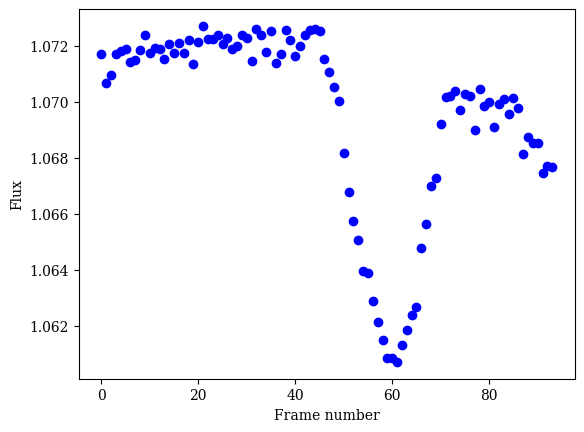

In [525]:
plt.figure()
plt.plot(f1.sum(axis=1)/f2.sum(axis=1),'bo')
plt.ylabel('Flux')
plt.xlabel('Frame number')
plt.show()

Ok, so there is some noise in the final 4 points and I know from the ancillary_plots.pdf figures that the sky is brightening for final 4 frames so I'll remove these.

Also plot the sky flux to check for clouds.

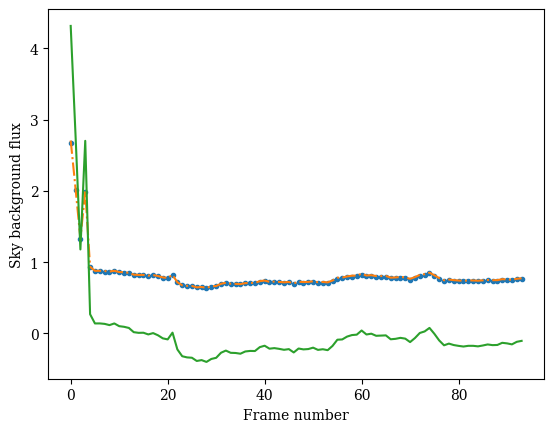

In [528]:
plt.figure()
plt.plot(sky1.mean(axis=1),'.')
plt.plot(sky2.mean(axis=1),'-.')
plt.plot(sky.mean(axis=1))
plt.ylabel('Sky background flux')
plt.xlabel('Frame number')
plt.show()

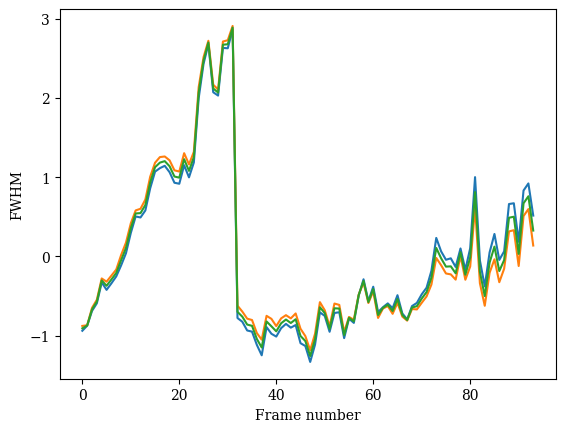

In [530]:
plt.figure()
plt.plot(fwhm1_norm)
plt.plot(fwhm2_norm)
plt.plot(fwhm_norm)
plt.ylabel('FWHM')
plt.xlabel('Frame number')
plt.show()

In addition to the steep increase in the sky background at the end of the night, there is also a sharp increase in frame 5 which is likely due to clouds and can be removed by hand.

So we'll remove frame 5, and all frames > 84 from the arrays, done by hand as:

94
94
89
89
89


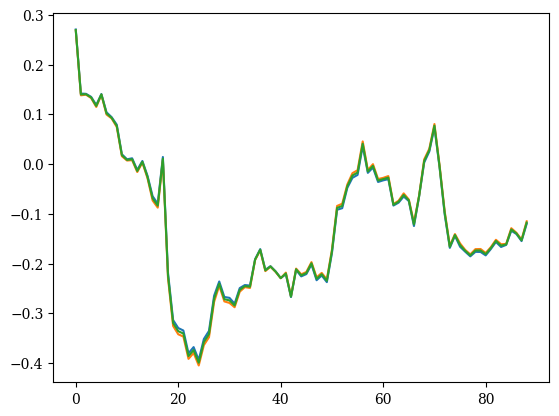

In [533]:
print(len(mjd))
print(len(fwhm_norm))
end_idx = -1
start_idx = 4

am = np.hstack((am[start_idx:end_idx]))
f1 = np.vstack((f1[start_idx:end_idx]))
f2 = np.vstack((f2[start_idx:end_idx]))

e1 = np.vstack((e1[start_idx:end_idx]))
e2 = np.vstack((e2[start_idx:end_idx]))

mjd = np.hstack((mjd[start_idx:end_idx]))

exp_times = np.hstack((exp_times[start_idx:end_idx]))

sky1 = np.vstack((sky1[start_idx:end_idx]))
sky2 = np.vstack((sky2[start_idx:end_idx]))

#sky_ratio = np.vstack((sky_ratio[:4],sky_ratio[5:84]))
sky1_norm = np.vstack((sky1_norm[start_idx:end_idx]))
sky2_norm = np.vstack((sky2_norm[start_idx:end_idx]))
sky = np.vstack((sky[start_idx:end_idx]))

fwhm1 = np.hstack((fwhm1[start_idx:end_idx]))
fwhm2 = np.hstack((fwhm2[start_idx:end_idx]))
fwhm1_norm = np.hstack((fwhm1_norm[start_idx:end_idx]))
fwhm2_norm = np.hstack((fwhm2_norm[start_idx:end_idx]))
#fwhm = np.hstack((fwhm[:4],fwhm[5:84]))
fwhm_norm = np.hstack((fwhm_norm[start_idx:end_idx]))

#xpos1 = np.hstack((xpos1[:4],xpos1[5:84]))
#xpos2 = np.hstack((xpos2[:4],xpos2[5:84]))
xpos1 = np.vstack((xpos1_norm[start_idx:end_idx]))
xpos2 = np.vstack((xpos2_norm[start_idx:end_idx]))

nframes = len(f1)
print(len(mjd))
print(len(fwhm_norm))
print(len(xpos1))

plt.plot(sky1_norm.mean(axis=1))
plt.plot(sky2_norm.mean(axis=1))
plt.plot(sky.mean(axis=1))

ancillary_data = {}
ancillary_data['sky1'] = sky1_norm
ancillary_data['sky2'] = sky2_norm
ancillary_data['sky'] = sky
ancillary_data['xpos1'] = xpos1
ancillary_data['xpos2'] = xpos2

#ancillary_data['sky_ratio'] = sky_ratio

And the contact points from the white light curve:

In [536]:
contact1 =41
contact4 = 68

Now we can plot the spectra to begin defining where the bins should be located.

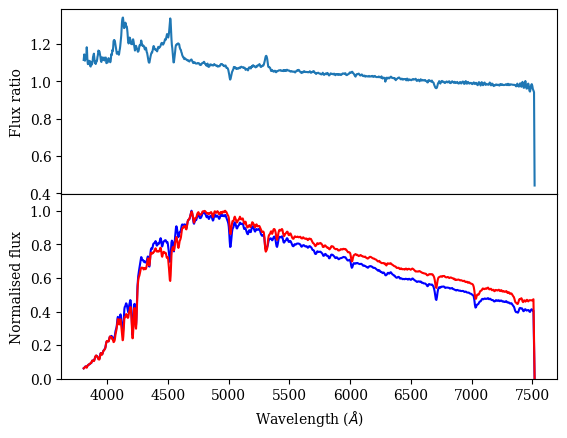

In [539]:

wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1)#,telluric=True)


### Spectroscopic bins

Now we begin the iterative process of defining bin edges. We want to go as narrow as possible (100-250A) and cover as much wavelength range (4000-9250A) while avoiding bin edges falling on strong stellar/telluric absorption lines and making sure the noise in the resulting light curves is not too severe.

Using bins I made earlier (with wider bins for the blue and red edges)...

In [542]:

#bin_edges = [4500,4910,5230,5480,5730,5980,6230,6480,6730,6980,7120,7370,\
#             7530,7870,8120,8370,8650,8900,9200]

# WHAT I USED
#bin_edges = [4500,4750,4950,5150,5350,5550,5750,5850,5940,6040,6240,6440,6640,6800,7040,7240,7440,\
#             7740,7940,8140,8340,8540,8740,8940,9200]

bin_edges = [4950,5150,5350,5550,5750,5850,5940,6040,6240,6440,6640,6800,7040,7240,7440,\
             7740,7940,8140,8340,8540,8740]

bin_edges = [3950,4190,4400,4600,4750,4950,5150,5350,5550,5750,5850,5940,6040,6240,6440,6640,6800,7040,7240,7440]

nbins = len(bin_edges) - 1

bin_centres = np.array([(bin_edges[i+1]+bin_edges[i])/2 for i in range(nbins)])
bin_widths = np.array([(bin_edges[i+1]-bin_edges[i]) for i in range(nbins)])

print(bin_centres)

print(bin_widths)



[4070. 4295. 4500. 4675. 4850. 5050. 5250. 5450. 5650. 5800. 5895. 5990.
 6140. 6340. 6540. 6720. 6920. 7140. 7340.]
[240 210 200 150 200 200 200 200 200 100  90 100 200 200 200 160 240 200
 200]


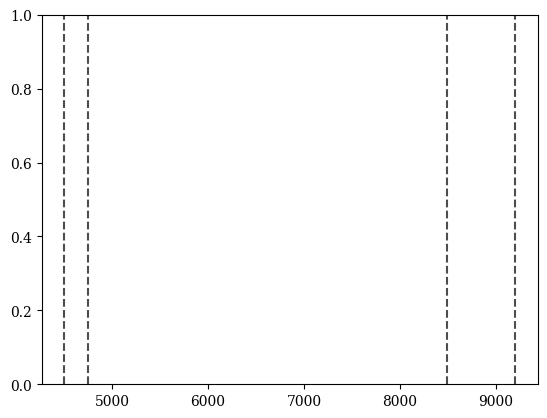

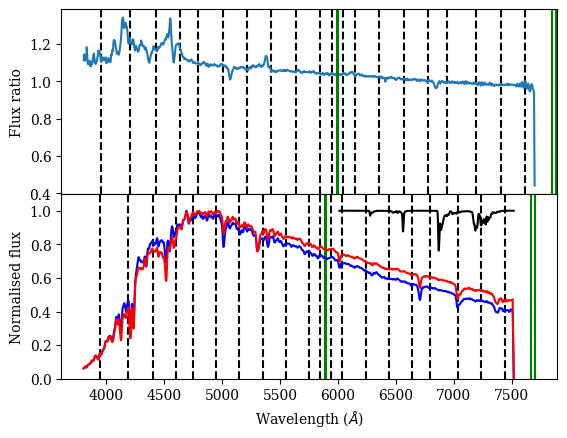

<Figure size 640x480 with 0 Axes>

In [544]:
plt.rcParams['font.family']='serif'

plt.axvline(x=4500,color=(0.3,0.3,0.3,1.0),linestyle='--')
plt.axvline(x=4750,color=(0.3,0.3,0.3,1.0),linestyle='--')
plt.axvline(x=8490,color=(0.3,0.3,0.3,1.0),linestyle='--')
plt.axvline(x=9200,color=(0.3,0.3,0.3,1.0),linestyle='--')
wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,\
                bin_edges=bin_edges,ratio=True,save_fig=True,alkali=True,telluric=True)

plt.savefig('spectrum_edited.pdf')

So this is perhaps overly zealous in removing the red and blue edges.

Now make the spectroscopic light curves by portioning the spectra into the above bins and making light curves for each bin. We also need to portion out the ancillary data (sky flux and x position) into the same bins for use in the fitting process later on.

In [547]:
help(wb.wvl_bin_data)

Help on function wvl_bin_data in module reduction_utils.wavelength_binning:

wvl_bin_data(flux1, err1, flux2, err2, wvl_solution, bins, ancillary_data=None, weighted=False, n_tukey_points=0, wvl_solution_2=None)
    A function to bin the spectra of the target and comparison to make spectroscopic light curves for each by summing the flux within the defined wavelength bins.
    The target's light curves are divided by the comparison's light curves to correct for telluric extinction.
    
    Inputs:
    flux1 - ndarray of spectra of the target
    err1 - ndarray of errors of the target
    flux2 - ndarray of spectra of the comparison
    err2 - ndarray of errors of the comparison
    wvl_solution - the wavelength solution which is used to bin the data. This is assuming that both the target and the comparison have been resampled onto the same x-axis.
                   My tests show that this provides much better light curves than using separate wavelength solutions
    bins - the list of

In [549]:
#bin_fluxes,bin_errors,bin_fluxes_target,bin_errors_target,bin_fluxes_comp,bin_errors_comp,\
#bin_xpos,bin_sky,photon_noise_star1,photon_noise_star2 = \
#wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,bin_edges,n_tukey_points=0,weighted=False)#xpos=xpos,sky=sky,


#bin_fluxes,bin_errors,binned_flux1,binned_err1,binned_flux2,binned_err2,bin_ancillary,photon_noise_star1, photon_noise_star2,snr1,sn2 = \

bin_fluxes,bin_errors,bin_fluxes_target,bin_errors_target,bin_fluxes_comp,bin_errors_comp,binned_ancillary,photon_noise_star1,photon_noise_star2,SN1,SN2 = \
wb.wvl_bin_data(f1,e1,f2,e2,
                wvl_solution_1,
                bin_edges,
                ancillary_data=ancillary_data,
                n_tukey_points=0,
                weighted=False)#xpos=xpos,sky=sky,

Now normalise the light curves to the out of transit data and plot:

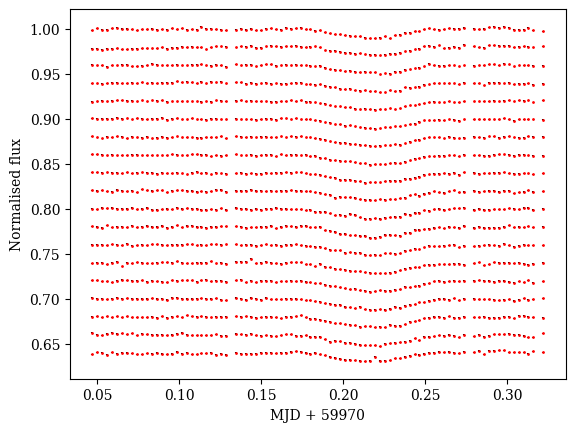

[59970.0470559  59970.05007881 59970.05310021 59970.0561208
 59970.05914475 59970.06216894 59970.06519197 59970.06821071
 59970.07123512 59970.07425664 59970.07727643 59970.08029911
 59970.08331994 59970.08633879 59970.08936134 59970.09238159
 59970.09540206 59970.09842381 59970.10144371 59970.10446407
 59970.10748409 59970.11050652 59970.11352804 59970.1165469
 59970.11956726 59970.12258715 59970.1256074  59970.12862556
 59970.13466941 59970.13769035 59970.14070967 59970.14372968
 59970.14675143 59970.14977145 59970.15279505 59970.15581669
 59970.15883577 59970.16185637 59970.16487928 59970.16789871
 59970.17092348 59970.17394488 59970.17696501 59970.17999105
 59970.18301442 59970.1860393  59970.18906487 59970.1920813
 59970.19510235 59970.19812607 59970.20114805 59970.20417409
 59970.20719711 59970.21021794 59970.21323876 59970.21625959
 59970.21928017 59970.22229891 59970.22532205 59970.22834114
 59970.2313637  59970.23438823 59970.23740963 59970.24043115
 59970.24344687 59970.24646

In [552]:
nf, ne = wb.normalise_flux(bin_fluxes,bin_errors,contact1,contact4)

wb.plot_all_bins(mjd,nf,ne)

print(mjd)
print(binned_ancillary['sky1'])

So these are our spectroscopic (wavelength-binned) light curves going from blue (top) to red (bottom). Ultimately what we are trying to determine is whether the depth of the transit varies between these light curves.

If we're happy, save the output:

In [555]:
np.mean(sky)

-0.12204433770763912

In [565]:
from pathlib import Path

folder_name = 'pickled_objects/wvl_bins_16June2025/'
path_create = Path(parent_direc+folder_name)
path_create.mkdir(parents=True, exist_ok=True)

pickle.dump(nf,open(parent_direc+folder_name+'fluxes.pickle','wb'))
pickle.dump(ne,open(parent_direc+folder_name+'errors.pickle','wb'))
pickle.dump(am,open(parent_direc+folder_name+'airmass.pickle','wb'))
pickle.dump(mjd-59970,open(parent_direc+folder_name+'time.pickle','wb'))

pickle.dump(bin_centres,open(parent_direc+folder_name+'wvl_bin_centres.pickle','wb'))
pickle.dump(bin_widths,open(parent_direc+folder_name+'wvl_bin_full_widths.pickle','wb'))

pickle.dump(binned_ancillary['xpos1'],open(parent_direc+folder_name+'xpos1.pickle','wb'))
pickle.dump(binned_ancillary['xpos2'],open(parent_direc+folder_name+'xpos2.pickle','wb'))
pickle.dump(binned_ancillary['sky1'],open(parent_direc+folder_name+'sky1.pickle','wb'))
pickle.dump(binned_ancillary['sky'],open(parent_direc+folder_name+'sky.pickle','wb'))
pickle.dump(binned_ancillary['sky2'],open(parent_direc+folder_name+'sky2.pickle','wb'))
#pickle.dump(binned_ancillary['sky_ratio'],open(parent_direc+'pickled_objects/wvl_bins4/sky_ratio.pickle','wb'))
pickle.dump(fwhm1_norm,open(parent_direc+folder_name+'fwhm1.pickle','wb'))
pickle.dump(fwhm2_norm,open(parent_direc+folder_name+'fwhm2.pickle','wb'))
pickle.dump(fwhm_norm,open(parent_direc+folder_name+'fwhm.pickle','wb'))

pickle.dump(photon_noise_star1,open(parent_direc+folder_name+'photon_noise_star1.pickle','wb'))
pickle.dump(photon_noise_star2,open(parent_direc+folder_name+'photon_noise_star2.pickle','wb'))

In [567]:
print(len(nf))
print(len(ne))
print(len(am))
print(len(mjd))
print(len(binned_ancillary['xpos1']))
print(len(binned_ancillary['sky']))

19
19
89
89
19
19


In [569]:
am

array([1.118, 1.112, 1.106, 1.101, 1.096, 1.091, 1.086, 1.082, 1.078,
       1.075, 1.071, 1.068, 1.065, 1.062, 1.06 , 1.058, 1.056, 1.054,
       1.053, 1.051, 1.05 , 1.05 , 1.049, 1.049, 1.049, 1.049, 1.05 ,
       1.05 , 1.052, 1.054, 1.056, 1.057, 1.06 , 1.062, 1.065, 1.068,
       1.071, 1.074, 1.078, 1.082, 1.086, 1.091, 1.095, 1.1  , 1.106,
       1.111, 1.117, 1.124, 1.13 , 1.137, 1.144, 1.152, 1.16 , 1.168,
       1.177, 1.186, 1.195, 1.205, 1.215, 1.226, 1.237, 1.249, 1.261,
       1.273, 1.286, 1.3  , 1.314, 1.329, 1.344, 1.36 , 1.376, 1.393,
       1.411, 1.43 , 1.449, 1.49 , 1.512, 1.535, 1.558, 1.583, 1.609,
       1.636, 1.664, 1.693, 1.723, 1.755, 1.788, 1.823, 1.898])

### Sodium bins

We also want to make narrower bins centred on the sodium and potassium lines, which are expected to be strong absorption lines in the atmospheres of the planets we consider.

We do this in 2 ways, firstly by making a handful of narrow bins of uniform width centred on each feature and covering ~200A. And secondly by having a single bin centred on each feature and making a single light curve. We then incrementally increase this bin width by 10A, until the bin centred on the feature is ~100A wide. I call this 'incrementally increasing bins'.

First start off with 5 bins of 30A width centred on sodium:

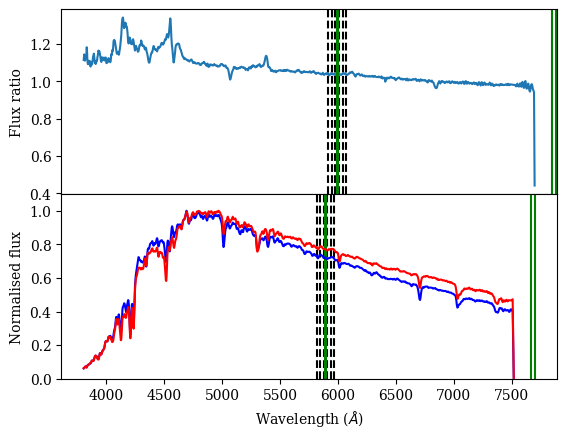

5893.0


In [606]:
no_bins_na = 5
bin_width_na = 30
na_centre = wb.sodium_centre

# Now make the wavelength bins for sodium
na_bins = np.arange(na_centre-(bin_width_na/2)*no_bins_na,na_centre+(bin_width_na/2)*(no_bins_na+1),bin_width_na)
na_bins_centres = np.array([(na_bins[i+1]+na_bins[i])/2 for i in range(no_bins_na)])
na_bins_widths = np.array([(na_bins[i+1]-na_bins[i]) for i in range(no_bins_na)])

# And plot these to make sure everything looks OK
wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,bin_edges=na_bins,alkali=True)

print(na_centre)



Ok, these look to be well centred on sodium, now make the light curves as before:

(I'm neglecting the flux of the target and comparison from the returned variables, hence defining them with the underscore)

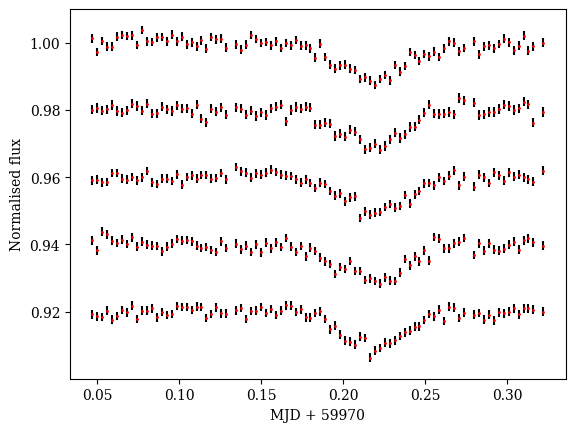

In [608]:
na_bins_fluxes,na_bins_errors,_,_,_,_,na_bins_ancillary_data,_,_,_,_ = \
wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,na_bins,n_tukey_points=0,ancillary_data=ancillary_data,weighted=False)

nf_na, ne_na = wb.normalise_flux(na_bins_fluxes,na_bins_errors,contact1,contact4)

wb.plot_all_bins(mjd,nf_na,ne_na)

These are noisier than the wider bins above but that's OK. Now save the output:

In [610]:
pickle.dump(nf_na,open(parent_direc+'pickled_objects/Na/fluxes.pickle','wb'))
pickle.dump(ne_na,open(parent_direc+'pickled_objects/Na/errors.pickle','wb'))

pickle.dump(na_bins_ancillary_data['xpos1'],open(parent_direc+'pickled_objects/Na/xpos1.pickle','wb'))
pickle.dump(na_bins_ancillary_data['xpos2'],open(parent_direc+'pickled_objects/Na/xpos2.pickle','wb'))
pickle.dump(na_bins_ancillary_data['sky1'],open(parent_direc+'pickled_objects/Na/sky1.pickle','wb'))
pickle.dump(na_bins_ancillary_data['sky2'],open(parent_direc+'pickled_objects/Na/sky2.pickle','wb'))
#pickle.dump(na_bins_sky,open(parent_direc+'pickled_objects/Na/sky.pickle','wb'))

pickle.dump(na_bins_centres,open(parent_direc+'pickled_objects/Na/bin_centres.pickle','wb'))
pickle.dump(na_bins_widths,open(parent_direc+'pickled_objects/Na/bin_widths.pickle','wb'))



In [612]:
print(na_bins_centres)

[5833. 5863. 5893. 5923. 5953.]


And make the 'incrementally increasing bins' (iib), starting from a width of 10A and increasing to 100A, in steps of 10A.

26


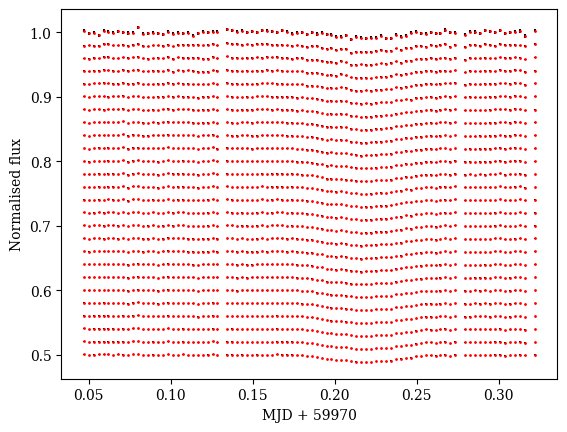

In [614]:
bin_widths_iib = np.arange(10,520,20)
print(len(bin_widths_iib))

iib_fluxes_Na = []
iib_errors_Na = []
iib_xpos_Na = []
iib_sky_Na = []
iib_centres_Na = []
iib_widths_Na = []

for i in bin_widths_iib:
    
    bin_left = na_centre - i/2
    bin_right = na_centre + i/2
    iib_centres_Na.append(na_centre)
    iib_widths_Na.append(i)
    
    curr_flux,curr_error,_,_,_,_,curr_ancillary_data,_,_,_,_ = wb.wvl_bin_data(f1,e1,f2,e2, wvl_solution_1,np.array([bin_left,bin_right]),n_tukey_points=0,ancillary_data=ancillary_data,weighted=False)

    iib_fluxes_Na.append(curr_flux[0])
    iib_errors_Na.append(curr_error[0])
    iib_xpos_Na.append(curr_ancillary_data['xpos1'][0])
    iib_sky_Na.append(curr_ancillary_data['sky1'][0])
    
iib_fluxes_Na = np.array(iib_fluxes_Na)
iib_errors_Na = np.array(iib_errors_Na)
iib_centres_Na = np.array(iib_centres_Na)
iib_widths_Na = np.array(iib_widths_Na)
iib_xpos_Na = np.array(iib_xpos_Na)
iib_sky_Na = np.array(iib_sky_Na)
    
nf_na_iib, ne_na_iib = wb.normalise_flux(iib_fluxes_Na,iib_errors_Na,contact1,contact4)

wb.plot_all_bins(mjd,nf_na_iib, ne_na_iib)

And save:

In [616]:
pickle.dump(nf_na_iib,open(parent_direc+'pickled_objects/Na/iib/fluxes.pickle','wb'))
pickle.dump(ne_na_iib,open(parent_direc+'pickled_objects/Na/iib/errors.pickle','wb'))

pickle.dump(iib_centres_Na,open(parent_direc+'pickled_objects/Na/iib/centres.pickle','wb'))
pickle.dump(iib_widths_Na,open(parent_direc+'pickled_objects/Na/iib/widths.pickle','wb'))

pickle.dump(iib_xpos_Na,open(parent_direc+'pickled_objects/Na/iib/xpos.pickle','wb'))
pickle.dump(iib_sky_Na,open(parent_direc+'pickled_objects/Na/iib/sky.pickle','wb'))

### Potassium bins

Now do the same for the potassium doublet. The difference here, however, is that the doublet has a larger separation (30A) than sodium (5A). It is also right next to the big telluric O2-A band absorption line. Therefore, I choose to centre on the redder of the two potassium lines.

In [ ]:
no_bins_K = 5
bin_width_K = 30

K_bins = np.arange(wb.potassium_d2-(bin_width_K/2)*no_bins_K,wb.potassium_d2+(bin_width_K/2)*(no_bins_K+1),bin_width_K)
K_bins_centres = np.array([(K_bins[i+1]+K_bins[i])/2 for i in range(no_bins_K)])
K_bins_widths = np.array([(K_bins[i+1]-K_bins[i]) for i in range(no_bins_K)])

wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,bin_edges=K_bins,alkali=True)

print(K_bins)


Again looks OK, but it's hard to tell as there's no stellar feature to guide the eye.

Now make the light curves.

In [ ]:
K_bins_fluxes,K_bins_errors,_,_,_,_,K_bins_xpos,K_bins_sky,_,_ = wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,\
                                                                            K_bins,n_tukey_points=0,\
                                                                                 xpos=xpos,sky=sky,weighted=False)

nf_K, ne_K = wb.normalise_flux(K_bins_fluxes,K_bins_errors,contact1,contact4)

wb.plot_all_bins(mjd,nf_K, ne_K)

Light curves look pretty good. Now save:

In [ ]:
# pickle.dump(nf_K,open('../pickled_objects/K/fluxes.pickle','wb'))
# pickle.dump(ne_K,open('../pickled_objects/K/errors.pickle','wb'))

# pickle.dump(K_bins_centres,open('../pickled_objects/K/centres.pickle','wb'))
# pickle.dump(K_bins_widths,open('../pickled_objects/K/widths.pickle','wb'))

# pickle.dump(K_bins_xpos,open('../pickled_objects/K/xpos.pickle','wb'))
# pickle.dump(K_bins_sky,open('../pickled_objects/K/sky.pickle','wb'))

For potassium iib, we centre the bin on the first line and step outwards to the right, to make sure we don't include too much of the telluric O2 line.

First find where the lines are in relation to the tellurics.

In [ ]:
wb.plot_spectra(f1[nframes//2],f2[nframes//2],wvl_solution_1,telluric=True)

OK, so K D1 occurs where telluric O2 is at approx 90% transmission. Make left hand edge where it reaches 70% transmission.

In [ ]:
telluric_wvl,telluric_flux = np.loadtxt('../line_lists/tellurics_halpha.dat',unpack=True)

# First only consider wavelength region of interest
telluric_wvl_cut = ((telluric_wvl > 7630) & (telluric_wvl < 7700))

# Now find the index where the transmission is greater than 70%
cut_index = min(np.where(telluric_flux[telluric_wvl_cut] >= 0.7)[0])

# And now find the wavelength where this occurs
print("Left hand K bin should be cut at %dA"%(telluric_wvl[telluric_wvl_cut][cut_index]))


In [ ]:

iib_fluxes_K = []
iib_errors_K = []
iib_xpos_K = []
iib_sky_K = []
iib_centres_K = []
iib_widths_K = []

 
for i in bin_widths_iib:
    
    # centering on potassium D1
    
    # left hand boundary is 7645A
    if wb.potassium_d1 - i/2 >= 7645:
        bin_left = wb.potassium_d1 - i/2
        bin_right = wb.potassium_d1 + i/2
        iib_centres_K.append(wb.potassium_d1)
        iib_widths_K.append(i)
    else: # bin expands towards the red
        bin_left = 7645
        bin_right = bin_left + i
        iib_centres_K.append((bin_left+bin_right)//2)
        iib_widths_K.append(i)
    
    curr_flux,curr_error,_,_,_,_,curr_xpos,curr_sky,_,_ = \
    wb.wvl_bin_data(f1,e1,f2,e2,wvl_solution_1,np.array([bin_left,bin_right]),\
                    n_tukey_points=0,xpos=xpos,sky=sky,weighted=False)

    iib_fluxes_K.append(curr_flux[0])
    iib_errors_K.append(curr_error[0])
    iib_xpos_K.append(curr_xpos[0])
    iib_sky_K.append(curr_sky[0])
    
iib_fluxes_K = np.array(iib_fluxes_K)
iib_errors_K = np.array(iib_errors_K)
iib_centres_K = np.array(iib_centres_K)
iib_widths_K = np.array(iib_widths_K)
iib_xpos_K = np.array(iib_xpos_K)
iib_sky_K = np.array(iib_sky_K)
    
nf_K_iib, ne_K_iib = wb.normalise_flux(iib_fluxes_K,iib_errors_K,contact1,contact4)

wb.plot_all_bins(mjd,nf_K_iib, ne_K_iib)

And save:

In [ ]:
# pickle.dump(nf_K_iib,open('../pickled_objects/K/iib/fluxes.pickle','wb'))
# pickle.dump(ne_K_iib,open('../pickled_objects/K/iib/errors.pickle','wb'))

# pickle.dump(iib_centres_K,open('../pickled_objects/K/iib/centres.pickle','wb'))
# pickle.dump(iib_widths_K,open('../pickled_objects/K/iib/widths.pickle','wb'))

# pickle.dump(iib_xpos_K,open('../pickled_objects/K/iib/xpos.pickle','wb'))
# pickle.dump(iib_sky_K,open('../pickled_objects/K/iib/sky.pickle','wb'))

Now we can move to notebook 6 - preparing the white light curve for fitting.